# Profiling and Analysis Questions


Clustering
https://web.ist.utl.pt/rmch/dash/guides/Clustering%20in%20Python.html


- what are the top aisle purchase clusters?
- what are the most common timeframe order time clusters (order_dow, order_hour_of_day,days_since_prior_order and weeks_since_prior_order) ?

PCA Resources
- https://www.kaggle.com/code/asindico/customer-segments-with-pca
- https://www.datacamp.com/tutorial/principal-component-analysis-in-python
- https://www.youtube.com/watch?v=8klqIM9UvAc
- https://www.youtube.com/watch?v=FD4DeN81ODY
- https://www.youtube.com/watch?v=HMOI_lkzW08

# File and libraries

In [36]:
import pandas as pd
import numpy as np


filepath=r'data\instacart_pre_proc.csv'

file_tag = "Instacart Market Basket"


## DSLabs

In [37]:
%run "scripts/dslabs_functions.py"

# data functions

In [38]:
%run "scripts/data_functions.py"

data_functions lodaded


# Load

In [39]:
test_data=True
# test_data=False


# Define the sampling function
def sample_user_orders(data, fraction=0.1):
    # Get unique user_ids and order_ids
    unique_user_orders = data[['user_id', 'order_id']].drop_duplicates()
    sampled_user_orders = unique_user_orders.sample(frac=fraction)
    
    # Filter the dataset to include only the sampled users and orders
    sampled_data = data[data[['user_id', 'order_id']].apply(tuple, axis=1).isin(sampled_user_orders.apply(tuple, axis=1))]
    return sampled_data



if test_data==True:

    data=pd.read_csv(filepath)

    # Apply the sampling to each group 0.5%
    sample=0.05
    data = sample_user_orders(data, fraction=sample)


else:
    data=pd.read_csv(filepath)

    # Apply the sampling to each group 1%
    sample=0.1
    data = sample_user_orders(data, fraction=sample)



data=enrich_instacart_df(data)



data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160768 entries, 0 to 160767
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_id                 160768 non-null  int64  
 1   product_id               160768 non-null  int64  
 2   add_to_cart_order        160768 non-null  int64  
 3   reordered                160768 non-null  int64  
 4   user_id                  160768 non-null  int64  
 5   order_number             160768 non-null  int64  
 6   order_dow                160768 non-null  int64  
 7   order_hour_of_day        160768 non-null  int64  
 8   days_since_prior_order   149698 non-null  float64
 9   order_time_of_day        160768 non-null  object 
 10  is_weekend               160768 non-null  int64  
 11  weeks_since_prior_order  149698 non-null  float64
 12  order_time_of_day_enc    160768 non-null  float64
 13  order_hour_of_day_sin    160768 non-null  float64
 14  orde

## variable type definition

In [40]:
from pandas import Series, to_numeric, to_datetime


id_cols=['order_id', 'product_id', 'user_id','aisle_id','department_id']
# data=data.drop(columns=id_cols, axis=1)


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": [], "id": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        elif c in id_cols:
            variable_types["id"].append(c)
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(data)
print(variable_types)

{'numeric': ['add_to_cart_order', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'weeks_since_prior_order', 'order_time_of_day_enc', 'order_hour_of_day_sin', 'order_hour_of_day_cos', 'order_dow_sin', 'order_dow_cos'], 'binary': ['reordered', 'is_weekend'], 'date': [], 'symbolic': ['order_time_of_day', 'product_name', 'aisle', 'department'], 'id': ['order_id', 'product_id', 'user_id', 'aisle_id', 'department_id']}


## drop nulls

- this will drop all first buying orders from the dataframe

In [41]:
# drop any null values
data=data.dropna()

# top aisle buying clusters

## aisle dataset preparation
- group order ids and dummify aisle

In [42]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


aisle_df = data.pivot_table(index='user_id', columns='aisle', values='product_id', aggfunc='count', fill_value=0)

aisle_df


aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
67,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
82,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
115,0,2,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## aisle clustering analysis

In [57]:
# Normalize the data
scaler = StandardScaler()
user_aisle_scaled = scaler.fit_transform(aisle_df)

user_aisle_scaled

array([[-0.05975486, -0.1945005 , -0.05248955, ...,  1.03077098,
        -0.07715516, -0.44565555],
       [-0.05975486, -0.1945005 , -0.05248955, ..., -0.40355656,
        -0.07715516, -0.44565555],
       [-0.05975486, -0.1945005 , -0.05248955, ...,  1.03077098,
        -0.07715516,  0.46975397],
       ...,
       [-0.05975486, -0.1945005 , -0.05248955, ..., -0.40355656,
        -0.07715516, -0.44565555],
       [-0.05975486, -0.1945005 , -0.05248955, ..., -0.40355656,
        -0.07715516, -0.44565555],
       [-0.05975486, -0.1945005 , -0.05248955, ..., -0.40355656,
        -0.07715516, -0.44565555]])

In [63]:
# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
y_pred_kmeans = kmeans.fit_predict(user_aisle_scaled)

agglo = AgglomerativeClustering(n_clusters=3)
y_pred_agglo = agglo.fit_predict(user_aisle_scaled)



## aisle clustering evaluation

In [64]:
silhouette_kmeans = silhouette_score(user_aisle_scaled, y_pred_kmeans)
silhouette_agglo = silhouette_score(user_aisle_scaled, y_pred_agglo)

print(f'Silhouette Score for KMeans: {silhouette_kmeans}')
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_agglo}')


Silhouette Score for KMeans: 0.23831969415103
Silhouette Score for Agglomerative Clustering: 0.4324101425475388


## aisle pca visualization

In [65]:
# Visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca_aisle = PCA(n_components=6)
user_aisle_pca = pca_aisle.fit_transform(user_aisle_scaled)

pca_aisle_df = pd.DataFrame(user_aisle_pca, columns=[f'PC{i+1}' for i in range(user_aisle_pca.shape[1])])
pca_aisle_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-2.312759,0.498871,-0.135401,0.218246,-0.224715,-0.485551
1,-1.669051,-0.791101,-0.639770,-0.204980,0.213351,0.831208
2,-0.020407,-0.739061,-1.173635,-0.277260,0.457613,1.916714
3,0.690166,-1.139871,0.586064,0.608587,-0.762439,-1.096953
4,-1.983059,-0.045571,-0.275574,-0.089497,-0.241470,0.503462


## user aisle pca explained variance ratio

In [66]:
# Fit the PCA model
pca_aisle.fit(user_aisle_scaled)

# Explained variance ratio
explained_variance_reorder = pca_aisle.explained_variance_ratio_
print(f'Explained variance ratio: {explained_variance_reorder}')

Explained variance ratio: [0.03415664 0.01839314 0.01500977 0.01321404 0.01208058 0.01081506]


## user aisle pca plot

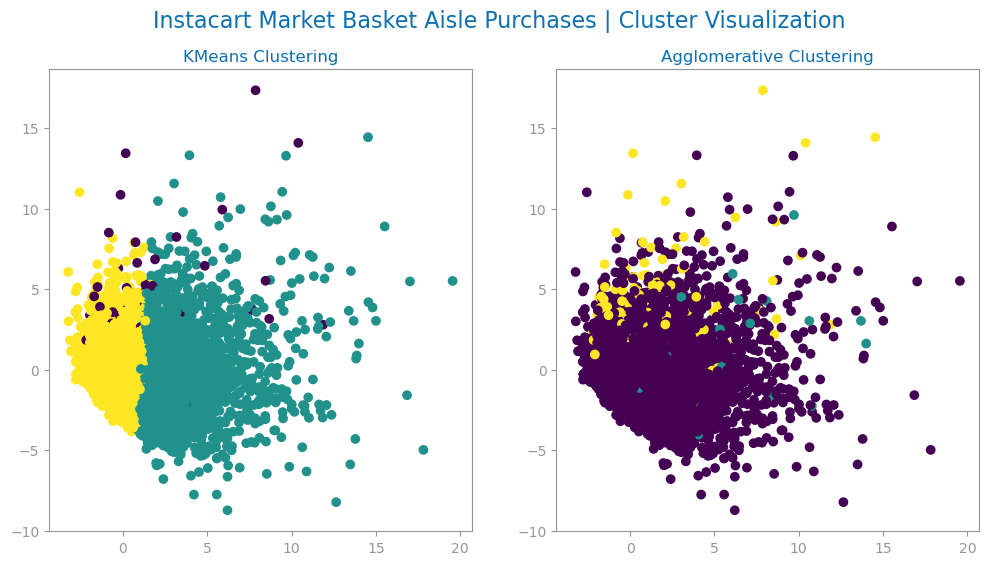

In [67]:

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(user_aisle_pca[:, 0], user_aisle_pca[:, 1], c=y_pred_kmeans)
plt.title(f'KMeans Clustering')

plt.subplot(122)
plt.scatter(user_aisle_pca[:, 0], user_aisle_pca[:, 1], c=y_pred_agglo)
plt.title(f'Agglomerative Clustering')

plt.suptitle(f"{file_tag} Aisle Purchases | Cluster Visualization", fontsize=16)

plt.show()

# Reorder Behaviour Clustering
- What are cart clusters that are more "refill" vs clusters where we have more "one shot order"?

## Reorder Data Prep

In [50]:
# Group by order_id and aggregate features
order_agg = data.groupby('order_id').agg({
    'add_to_cart_order': 'max',
    'reordered': 'mean'
}).rename(columns={'add_to_cart_order': 'num_products', 'reordered': 'reorder_rate'})

# Merge with orders data
order_data=data[['order_id','order_number','days_since_prior_order','is_weekend','weeks_since_prior_order','order_time_of_day_enc','order_hour_of_day_sin','order_hour_of_day_cos','order_dow_sin','order_dow_cos']].drop_duplicates()
       
order_agg = order_agg.merge(order_data, on='order_id')

# Dummify department IDs for reordered products
reordered = data[data['reordered'] == 1]
department_dummies = pd.get_dummies(reordered[['order_id', 'department']], columns=['department'])
department_dummies = department_dummies.groupby('order_id').sum().reset_index()

# Merge with aggregated order data
order_agg = order_agg.merge(department_dummies, on='order_id', how='left')

order_agg=order_agg.dropna()


order_agg

,order_id,num_products,reorder_rate,order_number,days_since_prior_order,is_weekend,weeks_since_prior_order,order_time_of_day_enc,order_hour_of_day_sin,order_hour_of_day_cos,...,department_household,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks
0,457,16,0.875000,16,30.0,0,4.0,3.141593,-0.942261,-0.334880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
2,745,3,0.333333,50,5.0,1,1.0,3.141593,-0.136167,-0.990686,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1724,15,0.600000,15,7.0,0,1.0,-1.570796,-0.979084,0.203456,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
4,1996,8,0.875000,4,30.0,0,4.0,3.141593,-0.136167,-0.990686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
5,2218,4,1.000000,52,4.0,0,1.0,-1.570796,-0.997669,-0.068242,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14986,3420027,2,1.000000,50,1.0,0,0.0,3.141593,-0.398401,-0.917211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14987,3420185,2,1.000000,32,7.0,0,1.0,1.570796,0.398401,-0.917211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14988,3420187,25,0.080000,5,30.0,0,4.0,3.141593,-0.136167,-0.990686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14989,3420589,5,1.000000,42,2.0,1,0.0,3.141593,-0.136167,-0.990686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


## Reorder feature selection and scaling

In [51]:
# Select relevant features for clustering
numeric_features = order_agg[['num_products','reorder_rate','order_number','days_since_prior_order','is_weekend','weeks_since_prior_order','order_time_of_day_enc','order_hour_of_day_sin','order_hour_of_day_cos','order_dow_sin','order_dow_cos']
                             + list(department_dummies.columns[1:])
                            ]

# Normalize the data
scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(numeric_features)


## Reorder Clustering and evaluation

In [52]:

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
y_pred_kmeans = kmeans.fit_predict(numeric_features_scaled)

agglo = AgglomerativeClustering(n_clusters=3)
y_pred_agglo = agglo.fit_predict(numeric_features_scaled)


In [53]:

from sklearn.metrics import silhouette_score, adjusted_rand_score


# Intrinsic Evaluation
silhouette_kmeans = silhouette_score(numeric_features_scaled, y_pred_kmeans)
silhouette_agglo = silhouette_score(numeric_features_scaled, y_pred_agglo)

print(f'Silhouette Score for KMeans: {silhouette_kmeans}')
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_agglo}')

# Extrinsic Evaluation
target = order_agg['reorder_rate']
adjusted_rand_kmeans = adjusted_rand_score(target.round(), y_pred_kmeans)
adjusted_rand_agglo = adjusted_rand_score(target.round(), y_pred_agglo)

print(f'Adjusted Rand Index for KMeans: {adjusted_rand_kmeans}')
print(f'Adjusted Rand Index for Agglomerative Clustering: {adjusted_rand_agglo}')

Silhouette Score for KMeans: 0.21191573176396025
Silhouette Score for Agglomerative Clustering: 0.0021846440601470947
Adjusted Rand Index for KMeans: -0.05337979754877505
Adjusted Rand Index for Agglomerative Clustering: 0.04046847122509089


## Reorder PCA visualization

In [54]:
# Visualization
pca_reorder = PCA(n_components=6)
numeric_features_pca = pca_reorder.fit_transform(numeric_features_scaled)

pca_df = pd.DataFrame(numeric_features_pca, columns=[f'PC{i+1}' for i in range(numeric_features_pca.shape[1])])
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,1.156531,2.594944,-0.251486,-0.768759,0.139512,-1.921682
1,-1.420435,-1.124956,-1.277028,2.265808,-0.391339,0.863691
2,0.516860,-0.165853,2.238661,0.343573,-1.660022,0.581160
3,0.116563,2.834982,-1.477679,-1.329014,0.936782,-1.956587
4,-0.486873,-1.802555,1.902174,0.024486,1.181018,-0.615075


## reorder pca explained variance ratio

In [55]:
# Fit the PCA model
pca_reorder.fit(numeric_features_scaled)

# Explained variance ratio
explained_variance_reorder = pca_reorder.explained_variance_ratio_
print(f'Explained variance ratio: {explained_variance_reorder}')


Explained variance ratio: [0.10737186 0.07283958 0.0593898  0.05133117 0.04002281 0.0356012 ]


## reorder pca plot

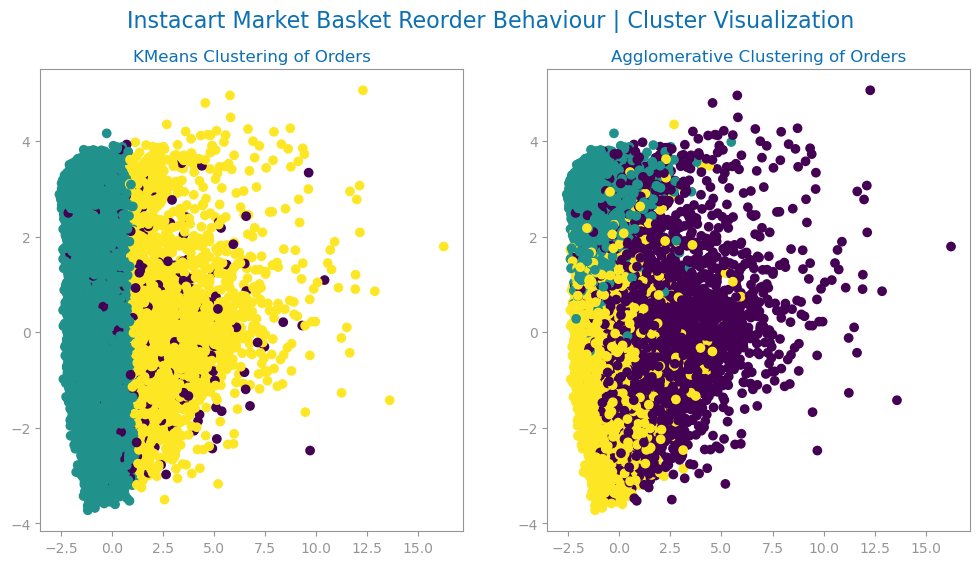

In [56]:

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(numeric_features_pca[:, 0], numeric_features_pca[:, 1], c=y_pred_kmeans)
plt.title('KMeans Clustering of Orders')

plt.subplot(122)
plt.scatter(numeric_features_pca[:, 0], numeric_features_pca[:, 1], c=y_pred_agglo)
plt.title('Agglomerative Clustering of Orders')


plt.suptitle(f"{file_tag} Reorder Behaviour | Cluster Visualization", fontsize=16)

plt.show()

# outputs
should we separate clusters by reordered vs not reordered?